In [1]:
using Pkg
Pkg.activate(".")
using LinearAlgebra, JSON, TextSearch, PyCall, StatsPlots, CodecZlib, Glob, CSV, DataFrames, TimeSeries, Dates, JLD2

  Activating environment at `~/Research/TextClassificationTutorial/emotion-timeline/Project.toml`


In [2]:
#] add JSON TextSearch PyCall StatsPlots CodecZlib Glob CSV DataFrames JLD2 TimeSeries

In [3]:
emolex = CSV.read("NRC-Emotion-Lexicon-v0.92-en-esTranslations.csv", DataFrame)
first(emolex, 10) |> display
names(emolex) |> display

,en,es,Positive,Negative,Anger,Anticipation,Disgust,Fear
,String31,String63,Int64,Int64,Int64,Int64,Int64,Int64
1,aback,detrás,0,0,0,0,0,0
2,abacus,ábaco,0,0,0,0,0,0
3,abandon,abandonar,0,1,0,0,0,1
4,abandoned,abandonado,0,1,1,0,0,1
5,abandonment,abandono,0,1,1,0,0,1
6,abate,disminuir,0,0,0,0,0,0
7,abatement,disminución,0,0,0,0,0,0
8,abba,Abba,1,0,0,0,0,0
9,abbot,abad,0,0,0,0,0,0


12-element Vector{String}:
 "en"
 "es"
 "Positive"
 "Negative"
 "Anger"
 "Anticipation"
 "Disgust"
 "Fear"
 "Joy"
 "Sadness"
 "Surprise"
 "Trust"

In [4]:
size(emolex)

(14182, 12)

In [5]:
const TOK = Tokenizer(TextConfig(del_diac=true, del_dup=false, del_punc=false, group_num=true, group_url=true, group_usr=false, group_emo=false, lc=true, qlist=[], nlist=[1], slist=[]))

function normtext(text)
    join(decode.(TOK, tokenize(TOK, text)), ' ')
end

function prototype(model, words)
    normalize!(sum(normalize!(model.get_sentence_vector(w)) for w in words))
end

function emovector(model, prototypes, message)
    v = normalize!(model.get_sentence_vector(normtext(message)))
    cosdist = NormalizedCosineDistance()
    
    [
        evaluate(cosdist, v, prototypes.positive),
        evaluate(cosdist, v, prototypes.negative),
        evaluate(cosdist, v, prototypes.anger),
        evaluate(cosdist, v, prototypes.anticipation),
        evaluate(cosdist, v, prototypes.disgust),
        evaluate(cosdist, v, prototypes.fear),
        evaluate(cosdist, v, prototypes.joy),
        evaluate(cosdist, v, prototypes.sadness),
        evaluate(cosdist, v, prototypes.surprise),
        evaluate(cosdist, v, prototypes.trust)
    ]
end

emovector (generic function with 1 method)

In [6]:

function create_prototypes(model, emolex)
    (
        positive=prototype(model, emolex.es[emolex.Positive .== 1]),
        negative=prototype(model, emolex.es[emolex.Negative .== 1]),
        anger=prototype(model, emolex.es[emolex.Anger .== 1]),
        anticipation=prototype(model, emolex.es[emolex.Anticipation .== 1]),
        disgust=prototype(model, emolex.es[emolex.Disgust .== 1]),
        fear=prototype(model, emolex.es[emolex.Fear .== 1]),
        joy=prototype(model, emolex.es[emolex.Joy .== 1]),
        sadness=prototype(model, emolex.es[emolex.Sadness .== 1]),
        surprise=prototype(model, emolex.es[emolex.Surprise .== 1]),
        trust=prototype(model, emolex.es[emolex.Trust .== 1])
    )
end


create_prototypes (generic function with 1 method)

In [7]:
fasttext = pyimport("fasttext")
mx = fasttext.load_model("MX.bin")
emolex[:, :es] = [normtext(w) for w in emolex.es]
prototypes = create_prototypes(mx, emolex)

(positive = Float32[0.10201293, 0.03246686, 0.09615584, -0.12936771, -0.032428954, 0.0143513875, 0.083337925, 0.02213102, 0.00029235127, -0.03227668  …  0.0964679, -0.016574789, -0.03494121, 0.061685447, 0.03420058, -0.046953466, -0.02301845, 0.04765465, -0.055896193, -0.013013872], negative = Float32[0.072958395, -0.04289603, 0.06987861, -0.080902606, -0.03538343, -0.0054505486, 0.071728416, -0.004113946, 0.017836584, -0.00023824762  …  0.12739655, -0.036191028, -0.013770341, 0.08731198, 0.031604383, -0.059108183, 0.045031026, 0.027566172, -0.043874085, 0.017165063], anger = Float32[0.052137647, -0.052533977, 0.05940342, -0.07047014, -0.029844834, -0.008424021, 0.058408424, 0.01316525, 0.009320093, 0.0037620242  …  0.12213537, -0.033306703, -0.013886006, 0.09289971, 0.021680754, -0.06154755, 0.046713226, 0.041259594, -0.03361854, 0.015141237], anticipation = Float32[0.09840373, 0.025600275, 0.08474409, -0.11887541, -0.013000074, 0.014707243, 0.0928321, 0.008533122, -0.00050762604, -0.

In [8]:
df = DataFrame(
    timestamp=DateTime[],
    positive=Float32[],
    negative=Float32[],
    anger=Float32[],
    anticipation=Float32[],
    disgust=Float32[],
    fear=Float32[],
    joy=Float32[],
    sadness=Float32[],
    surprise=Float32[],
    trust=Float32[]
)

for filename in glob("2021-10/MX*.json.gz")[1:10]
    open(filename) do f
        for line in eachline(GzipDecompressorStream(f))
            t = JSON.parse(line)
            vec = emovector(mx, prototypes, t["text"])
            ts = Dates.unix2datetime(parse(Int, t["timestamp_ms"]) / 1000)
            push!(df, (ts, vec...))
        end
    end
    @info filename
end

df 

┌ Info: 2021-10/MX20211001-00.json.gz
└ @ Main In[8]:24
┌ Info: 2021-10/MX20211001-01.json.gz
└ @ Main In[8]:24
┌ Info: 2021-10/MX20211001-02.json.gz
└ @ Main In[8]:24
┌ Info: 2021-10/MX20211001-03.json.gz
└ @ Main In[8]:24
┌ Info: 2021-10/MX20211001-04.json.gz
└ @ Main In[8]:24
┌ Info: 2021-10/MX20211001-05.json.gz
└ @ Main In[8]:24
┌ Info: 2021-10/MX20211001-06.json.gz
└ @ Main In[8]:24
┌ Info: 2021-10/MX20211001-07.json.gz
└ @ Main In[8]:24
┌ Info: 2021-10/MX20211001-08.json.gz
└ @ Main In[8]:24
┌ Info: 2021-10/MX20211001-09.json.gz
└ @ Main In[8]:24


,timestamp,positive,negative,anger,anticipation,disgust,fear
,DateTime,Float32,Float32,Float32,Float32,Float32,Float32
1,2021-10-01T04:59:55.153,0.319465,0.422393,0.440698,0.302078,0.451148,0.423802
2,2021-10-01T04:59:57.562,0.404873,0.420377,0.439738,0.397819,0.442179,0.439537
3,2021-10-01T04:59:57.749,0.524434,0.598463,0.615661,0.504428,0.624786,0.586755
4,2021-10-01T04:59:59.941,0.415839,0.43915,0.455489,0.395613,0.464207,0.446093
5,2021-10-01T05:00:01.164,0.348829,0.445771,0.481131,0.340493,0.47823,0.461909
6,2021-10-01T05:00:03.846,0.416778,0.457877,0.478064,0.391213,0.480367,0.465741
7,2021-10-01T05:00:04.030,0.683513,0.762319,0.782098,0.663741,0.786022,0.762757
8,2021-10-01T05:00:03.911,0.240611,0.321572,0.341937,0.22265,0.364463,0.322748
9,2021-10-01T05:00:06.141,0.341312,0.432116,0.456916,0.331147,0.465259,0.429146


In [9]:
#jldsave("emotions-mx-2021-10@1-14.jld2", timeline=df)
df = load("emotions-mx-2021-10@1-14.jld2", "timeline")

,timestamp,positive,negative,anger,anticipation,disgust,fear
,DateTime,Float32,Float32,Float32,Float32,Float32,Float32
1,2021-10-01T04:59:55.153,0.319465,0.422393,0.440698,0.302078,0.451148,0.423802
2,2021-10-01T04:59:57.562,0.404873,0.420377,0.439738,0.397819,0.442179,0.439537
3,2021-10-01T04:59:57.749,0.524434,0.598463,0.615661,0.504428,0.624786,0.586755
4,2021-10-01T04:59:59.941,0.415839,0.43915,0.455489,0.395613,0.464207,0.446093
5,2021-10-01T05:00:01.164,0.348829,0.445771,0.481131,0.340493,0.47823,0.461909
6,2021-10-01T05:00:03.846,0.416778,0.457877,0.478064,0.391213,0.480367,0.465741
7,2021-10-01T05:00:04.030,0.683513,0.762319,0.782098,0.663741,0.786022,0.762757
8,2021-10-01T05:00:03.911,0.240611,0.321572,0.341937,0.22265,0.364463,0.322748
9,2021-10-01T05:00:06.141,0.341312,0.432116,0.456916,0.331147,0.465259,0.429146


In [10]:
sort!(df, :timestamp)
ta = TimeArray(df, timestamp=:timestamp)
th = collapse(ta, hour, last)
td = collapse(ta, day, last)

14×10 TimeArray{Float32, 2, DateTime, Matrix{Float32}} 2021-10-01T23:59:59.035 to 2021-10-14T15:59:52.484
│                         │ positive │ negative │ anger  │ anticipation │⋯
├─────────────────────────┼──────────┼──────────┼────────┼──────────────┤
│ 2021-10-01T23:59:59.035 │ 0.4872   │ 0.5488   │ 0.5644 │ 0.4824       │
│ 2021-10-02T23:59:59.373 │ 0.3025   │ 0.3191   │ 0.3416 │ 0.2741       │
│ 2021-10-03T23:59:59.947 │ 0.4612   │ 0.4737   │ 0.5011 │ 0.453        │⋯
│ 2021-10-04T23:59:59.536 │ 0.238    │ 0.3366   │ 0.3584 │ 0.2299       │
│ 2021-10-05T23:59:57.692 │ 0.3467   │ 0.3738   │ 0.3913 │ 0.3249       │
│ 2021-10-06T22:05:52.978 │ 0.2843   │ 0.2937   │ 0.3208 │ 0.2482       │⋯
│ 2021-10-07T23:59:56.077 │ 0.3014   │ 0.3624   │ 0.3856 │ 0.2715       │
│ 2021-10-08T23:59:59.177 │ 0.3742   │ 0.4423   │ 0.4731 │ 0.345        │
│ 2021-10-09T23:59:59.103 │ 0.3771   │ 0.4547   │ 0.4751 │ 0.3774       │⋯
│ 2021-10-10T23:59:59.262 │ 0.2328   │ 0.2976   │ 0.3185 │ 0.2243       │
│ 

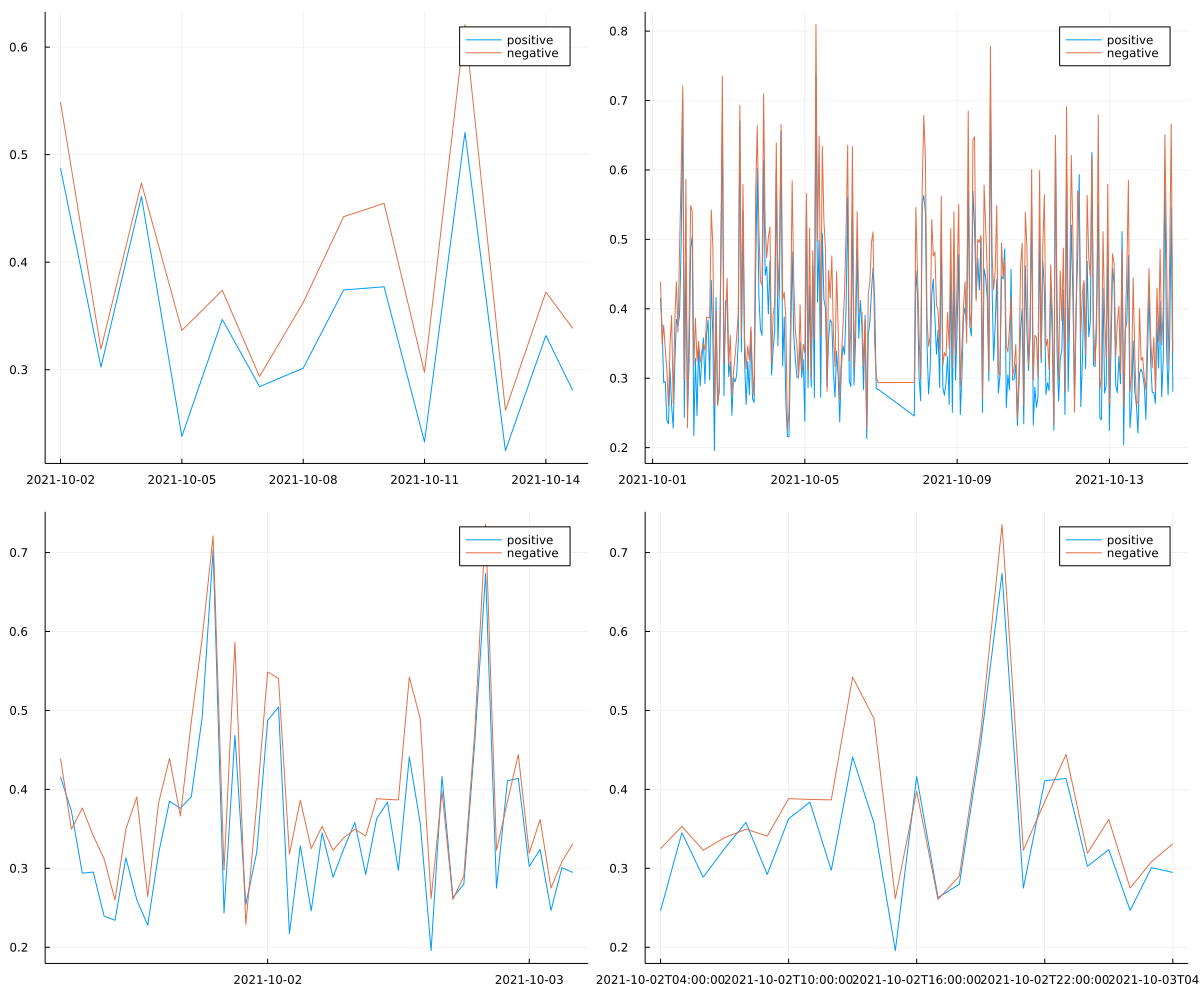

In [11]:
p1 = plot(td[[:positive, :negative]])
p2 = plot(th[[:positive, :negative]])
p3 = plot(th[[:positive, :negative]][1:48])
p4 = plot(th[[:positive, :negative]][24:48])

plot(p1, p2, p3, p4, size=(1200, 1000))

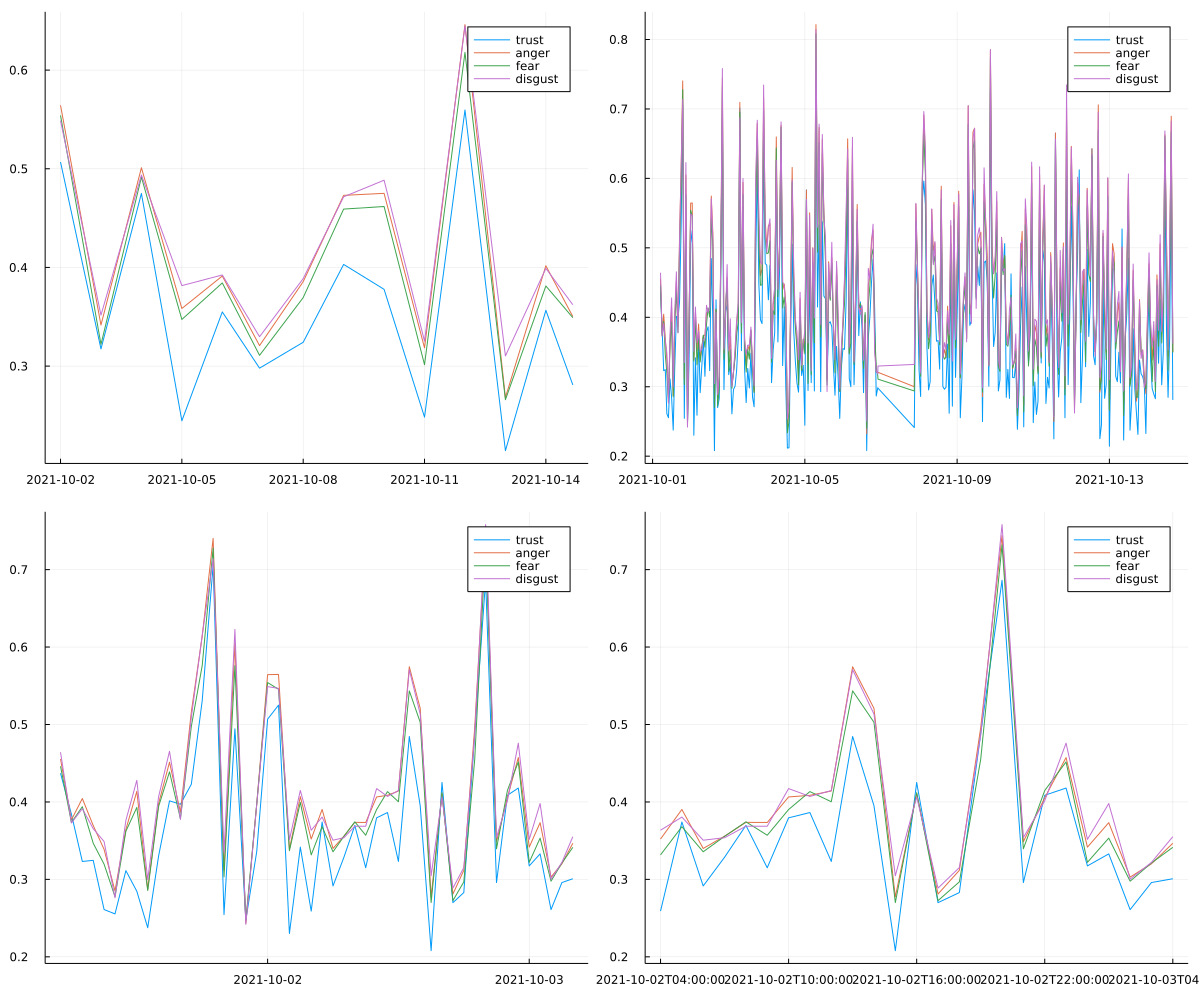

In [12]:
p1 = plot(td[[:trust, :anger, :fear, :disgust]])
p2 = plot(th[[:trust, :anger, :fear, :disgust]])
p3 = plot(th[[:trust, :anger, :fear, :disgust]][1:48])
p4 = plot(th[[:trust, :anger, :fear, :disgust]][24:48])

plot(p1, p2, p3, p4, size=(1200, 1000))